In [ ]:
! pip install pykan imblearn iterative-stratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from numpy.random import normal
from numpy.linalg import inv
from scipy.signal import cont2discrete
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import resample

from tqdm import tqdm
from kan import KAN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, balanced_accuracy_score, precision_recall_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import sympy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/SUMMER_RESEARCH/Data/wmean.csv')

X = data.drop(columns=['target_depression', 'target_anxiety', 'target_sleep'])
y = data[['target_depression', 'target_anxiety', 'target_sleep']].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y['target_depression'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)

# SMOTE VARIATIONS

# SMOTE on all labels

In [ ]:
y_joint = y_train.astype(int).astype(str).agg(''.join, axis=1)

class_counts = y_joint.value_counts()
min_count = class_counts.min()
k_eff = max(1, min(5, int(min_count) - 1))

if min_count < 2:
    X_train_res = X_train.copy().reset_index(drop=True)
    y_train_res = y_train.copy().reset_index(drop=True)
else:
    smote = SMOTE(random_state=23, k_neighbors=k_eff, sampling_strategy="auto")
    X_res, y_joint_res = smote.fit_resample(X_train, y_joint)

    y_joint_res = pd.Series(y_joint_res, name='joint').astype(str).str.zfill(3)
    y_train_res = y_joint_res.str.extract(
        r'(?P<target_depression>[01])(?P<target_anxiety>[01])(?P<target_sleep>[01])'
    ).astype(int)

    X_train_res = pd.DataFrame(X_res, columns=X_train.columns).reset_index(drop=True)

print("Train size:", len(X_train), "→", len(X_train_res))
print("Joint-class counts after SMOTE:\n", y_train_res.astype(str).agg(''.join, axis=1).value_counts())


Train size: 1008 → 2072
Joint-class counts after SMOTE:
 001    259
011    259
000    259
111    259
100    259
010    259
110    259
101    259
Name: count, dtype: int64


# SMOTE only on depression

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y['target_depression'])  # stratify on depression
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)

def depression_only_smote(X_train: pd.DataFrame, y_train: pd.DataFrame, k_neighbors=5, random_state=23):

    y_dep = y_train['target_depression'].values
    sm = SMOTE(random_state=random_state, k_neighbors=min(k_neighbors, sum(y_dep==1)-1))
    X_sm, y_dep_sm = sm.fit_resample(X_train.values, y_dep)

    n_orig = len(X_train)
    n_res  = len(X_sm)
    n_new  = n_res - n_orig
    if n_new <= 0:
        return X_train.reset_index(drop=True), y_train.reset_index(drop=True)

    X_new = X_sm[n_orig:, :]
    mask_dep1 = (y_train['target_depression'].values == 1)
    X_dep1_real = X_train.values[mask_dep1]
    Y_aux_real  = y_train.loc[mask_dep1, ['target_anxiety', 'target_sleep']].values

    k_eff = min(k_neighbors, max(1, len(X_dep1_real)-1))
    knn = KNeighborsClassifier(n_neighbors=k_eff, weights='distance')
    knn.fit(X_dep1_real, Y_aux_real)
    Y_aux_new = knn.predict(X_new)

    y_res = y_train.copy().reset_index(drop=True)
    y_new_df = pd.DataFrame({
        'target_depression': np.ones(n_new, dtype=int),
        'target_anxiety': Y_aux_new[:, 0].astype(int),
        'target_sleep': Y_aux_new[:, 1].astype(int)
    })
    y_res = pd.concat([y_res, y_new_df], axis=0, ignore_index=True)

    X_res = pd.DataFrame(X_sm, columns=X_train.columns).reset_index(drop=True)
    return X_res, y_res

X_train_bal, y_train_bal = depression_only_smote(X_train, y_train, k_neighbors=5, random_state=23)

def to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

dataset = {
    'train_input': to_tensor(X_train_bal),
    'train_label': to_tensor(y_train_bal[['target_depression','target_anxiety','target_sleep']]),
    'val_input': to_tensor(X_val),
    'val_label': to_tensor(y_val[['target_depression','target_anxiety','target_sleep']]),
    'test_input': to_tensor(X_test),
    'test_label': to_tensor(y_test[['target_depression','target_anxiety','target_sleep']]),
}

dataset['train_label'] = dataset['train_label'].float()
dataset['val_label']   = dataset['val_label'].float()
dataset['test_label']  = dataset['test_label'].float()

# stratification + SMOTE

In [ ]:
def multilabel_iterative_split(X, Y, test_size=0.2, val_size=0.2, random_state=23):
    try:
        from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit as MSSS
        msss = MSSS(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, temp_idx = next(msss.split(X.values, Y.values))
        X_train, X_temp = X.iloc[train_idx], X.iloc[temp_idx]
        Y_train, Y_temp = Y.iloc[train_idx], Y.iloc[temp_idx]

        msss2 = MSSS(n_splits=1, test_size=val_size / (1 - test_size), random_state=random_state)
        val_idx, test_idx = next(msss2.split(X_temp.values, Y_temp.values))
        X_val, X_test = X_temp.iloc[val_idx],  X_temp.iloc[test_idx]
        Y_val, Y_test = Y_temp.iloc[val_idx],  Y_temp.iloc[test_idx]
    except Exception:

        dep_col = Y.columns[0]
        X_train, X_temp, Y_train, Y_temp = train_test_split(
            X, Y, test_size=test_size, random_state=random_state, stratify=Y[dep_col]
        )
        X_val, X_test, Y_val, Y_test = train_test_split(
            X_temp, Y_temp, test_size=val_size / (1 - test_size), random_state=random_state,
            stratify=Y_temp[dep_col]
        )
    return X_train.reset_index(drop=True), Y_train.reset_index(drop=True), \
           X_val.reset_index(drop=True),   Y_val.reset_index(drop=True), \
           X_test.reset_index(drop=True),  Y_test.reset_index(drop=True)

def mlsmote(
    X_train: pd.DataFrame,
    Y_train: pd.DataFrame,
    minority_threshold: int = None,
    k_neighbors: int = 5,
    samples_factor: float = 1.0,
    random_state: int = 23,
    focus_label_index: int = None
):
    rng = np.random.default_rng(random_state)
    X_np = X_train.to_numpy(dtype=float)
    Y_np = Y_train.to_numpy(dtype=int)
    n, L = Y_np.shape

    labelsets, counts = np.unique(Y_np, axis=0, return_counts=True)
    med = np.median(counts)
    thr = int(max(5, 0.5 * med)) if minority_threshold is None else int(minority_threshold)

    minority_mask = np.zeros(n, dtype=bool)
    for ls, c in zip(labelsets, counts):
        if c < thr:
            idx = np.where(np.all(Y_np == ls, axis=1))[0]
            minority_mask[idx] = True

    if focus_label_index is not None:
        minority_mask = np.logical_or(minority_mask, Y_np[:, focus_label_index] == 1)

    seed_idx = np.where(minority_mask)[0]
    if seed_idx.size <= 1:
        return X_train.copy(), Y_train.copy()

    k_eff = min(k_neighbors, seed_idx.size - 1)
    if k_eff < 1:
        return X_train.copy(), Y_train.copy()
    nn = NearestNeighbors(n_neighbors=k_eff + 1, metric='euclidean').fit(X_np[seed_idx])
    nn_ind = nn.kneighbors(return_distance=False)[:, 1:]

    n_new = int(seed_idx.size * samples_factor)
    synth_X, synth_Y = [], []

    for _ in range(n_new):
        i_pos = rng.integers(seed_idx.size)
        xi_idx = seed_idx[i_pos]
        j_rel = rng.integers(k_eff)
        xj_idx = seed_idx[nn_ind[i_pos, j_rel]]

        alpha = rng.random()
        x_new = X_np[xi_idx] + alpha * (X_np[xj_idx] - X_np[xi_idx])

        neigh_pool = [xi_idx] + list(seed_idx[nn_ind[i_pos]])
        y_vote = Y_np[neigh_pool].mean(axis=0)
        y_new = (y_vote >= 0.5).astype(int)

        synth_X.append(x_new)
        synth_Y.append(y_new)

    X_aug = pd.DataFrame(np.vstack([X_np, np.array(synth_X)]), columns=X_train.columns)
    Y_aug = pd.DataFrame(np.vstack([Y_np, np.array(synth_Y)]), columns=Y_train.columns).astype(int)
    return X_aug.reset_index(drop=True), Y_aug.reset_index(drop=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y['target_depression'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)

X_train_mls, y_train_mls = mlsmote(
    X_train, y_train,
    minority_threshold=None,
    k_neighbors=5,
    samples_factor=1.0,
    random_state=23,
    focus_label_index=0
)

print("Original train size:", len(X_train), " -> After MLSMOTE:", len(X_train_mls))
print("Depression pos rate before:", y_train['target_depression'].mean().round(3),
      " after:", y_train_mls['target_depression'].mean().round(3))

Original train size: 1008  -> After MLSMOTE: 1293
Depression pos rate before: 0.283  after: 0.441


# SMOTE + cleaning

In [ ]:
def smote_sleep_then_clean_safe(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    target_pos_rate: float = 0.45,
    k_neighbors: int = 5,
    random_state: int = 23,
    clean_with_tomek: bool = True
):

    sleep = y_train['target_sleep'].to_numpy().astype(int)
    n_pos = (sleep == 1).sum()
    n_neg = (sleep == 0).sum()
    if n_pos < 2:
        return X_train.reset_index(drop=True), y_train.reset_index(drop=True)

    r_curr = n_pos / max(n_neg, 1)
    r_tgt  = target_pos_rate / max(1 - target_pos_rate, 1e-9)

    if r_curr >= r_tgt:
        return X_train.reset_index(drop=True), y_train.reset_index(drop=True)

    k_eff = min(k_neighbors, max(1, n_pos - 1))
    sm = SMOTE(
        random_state=random_state,
        k_neighbors=k_eff,
        sampling_strategy=float(r_tgt)
    )
    X_sm, sleep_sm = sm.fit_resample(X_train.to_numpy(), sleep)
    n_orig = len(X_train)
    n_new  = len(X_sm) - n_orig
    if n_new <= 0:
        return X_train.reset_index(drop=True), y_train.reset_index(drop=True)

    X_new = X_sm[-n_new:, :]

    mask_sleep1_real = (sleep == 1)
    X_sleep1_real = X_train.to_numpy()[mask_sleep1_real]
    Y_aux_real = y_train.loc[mask_sleep1_real, ['target_depression', 'target_anxiety']].to_numpy()

    k_aux = min(k_neighbors, max(1, len(X_sleep1_real) - 1))
    aux_knn = KNeighborsClassifier(n_neighbors=k_aux, weights='distance')
    aux_knn.fit(X_sleep1_real, Y_aux_real)
    Y_aux_new = aux_knn.predict(X_new).astype(int)

    y_aug = y_train.copy().reset_index(drop=True)
    y_new_df = pd.DataFrame({
        'target_depression': Y_aux_new[:, 0],
        'target_anxiety':    Y_aux_new[:, 1],
        'target_sleep':      np.ones(n_new, dtype=int)
    })

    X_aug = pd.DataFrame(X_sm, columns=X_train.columns).reset_index(drop=True)
    y_aug = pd.concat([y_aug, y_new_df], axis=0, ignore_index=True)

    if clean_with_tomek:
        cleaner = TomekLinks()
        X_clean, sleep_clean = cleaner.fit_resample(X_aug, y_aug['target_sleep'])

        keep_idx = getattr(cleaner, 'sample_indices_', None)
        if keep_idx is not None:
            X_final = X_aug.iloc[keep_idx].reset_index(drop=True)
            y_final = y_aug.iloc[keep_idx].reset_index(drop=True)
            return X_final, y_final

        return pd.DataFrame(X_clean, columns=X_train.columns), y_aug.iloc[:len(X_clean)].reset_index(drop=True)

    return X_aug, y_aug

X_train_res, y_train_res = smote_sleep_then_clean_safe(
    X_train, y_train,
    target_pos_rate=0.45,
    k_neighbors=5,
    random_state=23,
    clean_with_tomek=True
)

print("Train size:", len(X_train), "->", len(X_train_res))
print("Sleep+ rate before:", y_train['target_sleep'].mean().round(3),
      "after:", y_train_res['target_sleep'].mean().round(3))

from imblearn.combine import SMOTETomek

from imblearn.under_sampling import TomekLinks
cleaner = TomekLinks()
X_clean, dep_clean = cleaner.fit_resample(X_train_res, y_train_res['target_depression'])
keep_idx = cleaner.sample_indices_ if hasattr(cleaner, 'sample_indices_') else None
if keep_idx is not None:
    X_train_res = X_train_res.iloc[keep_idx].reset_index(drop=True)
    y_train_res = y_train_res.iloc[keep_idx].reset_index(drop=True)

Train size: 1008 -> 1008
Sleep+ rate before: 0.613 after: 0.613


# Light SMOTE for depression (chosen)

In [ ]:
def smote_light_depression_safe(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    target_pos_rate: float = 0.45,
    k_neighbors: int = 5,
    random_state: int = 23,
):

    assert {'target_depression','target_anxiety','target_sleep'}.issubset(y_train.columns), \
        "y_train must have columns: target_depression, target_anxiety, target_sleep"

    y_dep = y_train['target_depression'].to_numpy().astype(int)
    n_pos = (y_dep == 1).sum()
    n_neg = (y_dep == 0).sum()
    if n_pos < 2 or n_neg < 1:
        return X_train.reset_index(drop=True), y_train.reset_index(drop=True)

    r_curr = n_pos / max(n_neg, 1)
    r_tgt  = target_pos_rate / max(1 - target_pos_rate, 1e-9)

    if r_curr >= r_tgt:
        return X_train.reset_index(drop=True), y_train.reset_index(drop=True)

    k_eff = min(k_neighbors, max(1, n_pos - 1))

    sm = SMOTE(random_state=random_state, k_neighbors=k_eff, sampling_strategy=float(r_tgt))
    X_sm, dep_sm = sm.fit_resample(X_train.to_numpy(), y_dep)

    n_orig = len(X_train)
    n_new  = len(X_sm) - n_orig
    if n_new <= 0:
        return X_train.reset_index(drop=True), y_train.reset_index(drop=True)

    X_new = X_sm[-n_new:, :]

    mask_dep1_real = (y_dep == 1)
    X_dep1_real = X_train.to_numpy()[mask_dep1_real]
    Y_aux_real  = y_train.loc[mask_dep1_real, ['target_anxiety','target_sleep']].to_numpy()

    k_aux = min(k_neighbors, max(1, len(X_dep1_real) - 1))
    if len(X_dep1_real) < 2:

        rng = np.random.default_rng(random_state)
        idx = rng.integers(len(Y_aux_real), size=n_new)
        Y_aux_new = Y_aux_real[idx]
    else:
        knn = KNeighborsClassifier(n_neighbors=k_aux, weights='distance')
        knn.fit(X_dep1_real, Y_aux_real)
        Y_aux_new = knn.predict(X_new).astype(int)


    y_new_df = pd.DataFrame({
        'target_depression': np.ones(n_new, dtype=int),
        'target_anxiety': Y_aux_new[:, 0],
        'target_sleep': Y_aux_new[:, 1]
    })


    X_train_bal = pd.DataFrame(X_sm, columns=X_train.columns).reset_index(drop=True)
    y_train_bal = pd.concat([y_train.reset_index(drop=True), y_new_df], ignore_index=True)

    return X_train_bal, y_train_bal

X_train_bal, y_train_bal = smote_light_depression_safe(X_train, y_train, target_pos_rate=0.4, k_neighbors=5, random_state=23)
print("Depression rate before:", y_train['target_depression'].mean().round(3),
      "after:", y_train_bal['target_depression'].mean().round(3))


Depression rate before: 0.283 after: 0.4


# KAN dataset

In [ ]:
dataset = {}

train_input = torch.tensor(X_train_bal.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train_bal.to_numpy(), dtype=torch.long).reshape(-1, 3)

val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long).reshape(-1, 3)

test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long).reshape(-1, 3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_input)
X_val_scaled = scaler.transform(val_input)
X_test_scaled = scaler.transform(test_input)

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

dataset['train_input'] = train_input.clone().detach().requires_grad_(True)
dataset['val_input'] = val_input.clone().detach()
dataset['test_input'] = test_input.clone().detach()

dataset['train_label'] = train_label.reshape(-1, 3).detach().clone().float().to(device)
dataset['val_label'] = val_label.reshape(-1, 3).detach().clone().float().to(device)
dataset['test_label'] = test_label.reshape(-1, 3).detach().clone().float().to(device)

print("=======================================")
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print('---------------------------------------')
print("Val data shape: {}".format(dataset['val_input'].shape))
print("Val target shape: {}".format(dataset['val_label'].shape))
print("====================================")

Train data shape: torch.Size([1205, 56])
Train target shape: torch.Size([1205, 3])
---------------------------------------
Val data shape: torch.Size([126, 56])
Val target shape: torch.Size([126, 3])


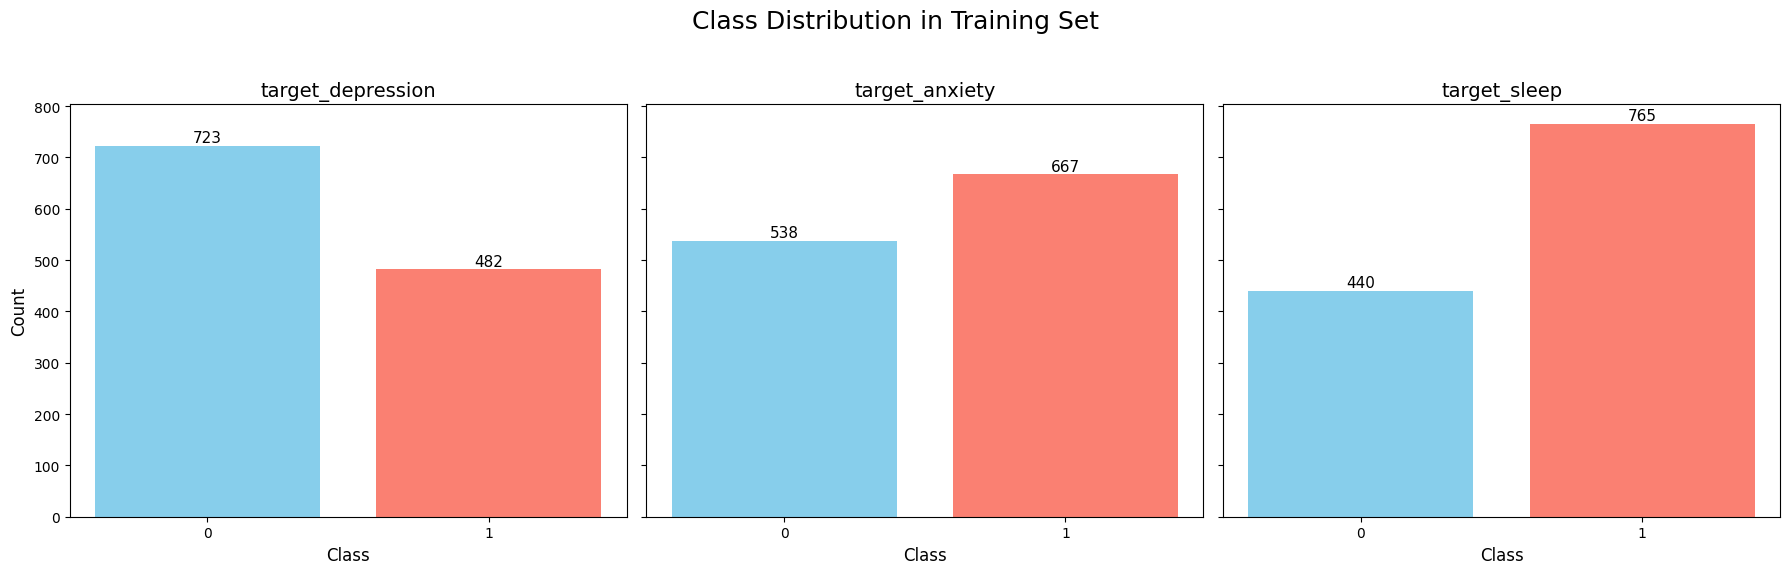

In [ ]:
tasks = ['target_depression', 'target_anxiety', 'target_sleep']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Class Distribution in Training Set', fontsize=18)

targets = [t.cpu().numpy().astype(int).ravel() for t in dataset['train_label'].T]

for i, target in enumerate(targets):
    counts = np.bincount(target, minlength=2)

    axes[i].bar(['0', '1'], counts, color=['skyblue', 'salmon'])
    axes[i].set_title(tasks[i], fontsize=14)
    axes[i].set_xlabel('Class', fontsize=12)
    if i == 0:
        axes[i].set_ylabel('Count', fontsize=12)

    for j, count in enumerate(counts):
        axes[i].text(j, count + 0.01 * max(counts), str(count), ha='center', fontsize=11)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
model = KAN(
    width=[dataset['train_input'].shape[1], 53, dataset['train_label'].shape[1]],
    grid=5,
    k=3,
    seed=23,
    device=device)

model(dataset['train_input'])

checkpoint directory created: ./model
saving model version 0.0


tensor([[    3.8477,  -626.8497,  -109.5115],
        [    9.1035,  -544.2912,   -84.7673],
        [   -3.4927,  -651.6310,   -90.8247],
        ...,
        [  -18.4091,  -625.3488,   -59.1303],
        [  -11.9781,  -609.9597,   -64.6218],
        [ -806.5607, -1059.9816,   497.2024]], grad_fn=<AddBackward0>)

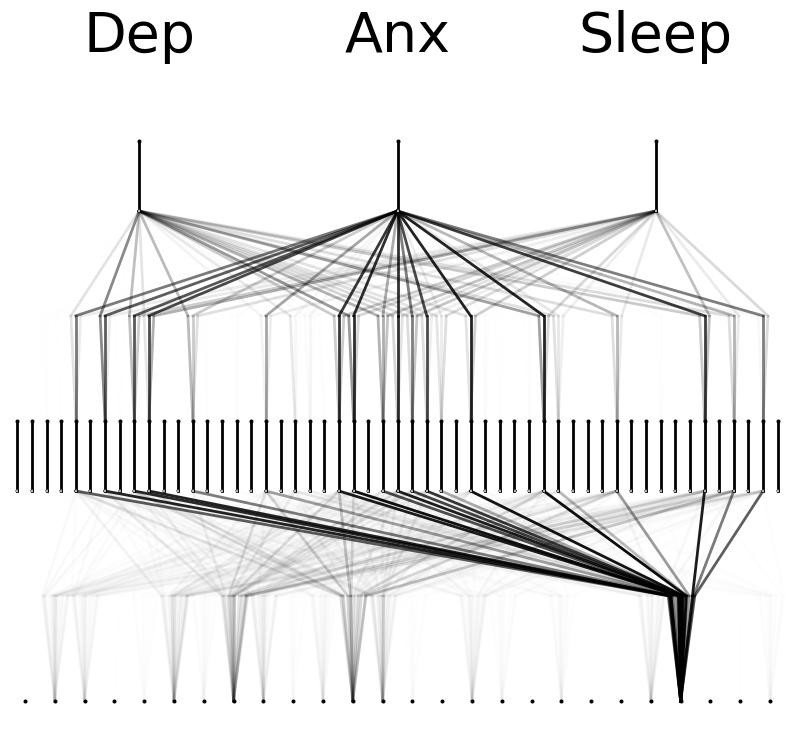

In [ ]:
model.plot(scale=1 , out_vars=['Dep', 'Anx', 'Sleep'])

In [ ]:
lambda_value = 1

def compute_pos_weight(y):
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    return torch.tensor([neg / pos], dtype=torch.float32)

pos_weight_dep = compute_pos_weight(y_train['target_depression'].values)
pos_weight_sleep = compute_pos_weight(y_train['target_sleep'].values)

def make_custom_loss_fn(lambda_weight):

    def custom_loss_fn(y_pred, y_true):

        y_true = y_true.float()

        dep_loss = F.binary_cross_entropy_with_logits(y_pred[:, 0], y_true[:, 0], pos_weight=pos_weight_dep)
        anx_loss = F.binary_cross_entropy_with_logits(y_pred[:, 1], y_true[:, 1])
        sleep_loss = F.binary_cross_entropy_with_logits(y_pred[:, 2], y_true[:, 2])

        return dep_loss + lambda_weight * (anx_loss + sleep_loss)

    return custom_loss_fn

In [ ]:
def train_acc():
    preds = (torch.sigmoid(model(dataset['train_input'])) >= 0.5).float()
    correct = (preds == dataset['train_label']).float()
    return correct.mean()

def val_acc():
    preds = (torch.sigmoid(model(dataset['val_input'])) >= 0.5).float()
    correct = (preds == dataset['val_label']).float()
    return correct.mean()


# TRAINING ROUND 1

In [ ]:
steps = 20

result = model.fit(
    {'train_input': dataset['train_input'], 'train_label': dataset['train_label'], 'test_input': dataset['val_input'], 'test_label': dataset['val_label']},
    opt="LBFGS",
    metrics=(train_acc, val_acc),
    loss_fn=make_custom_loss_fn(lambda_value),
    steps=steps,
    lamb=0.01
    )

| train_loss: 1.61e+00 | test_loss: 1.73e+00 | reg: 1.56e+02 | : 100%|█| 20/20 [06:52<00:00, 20.62s/


saving model version 0.1


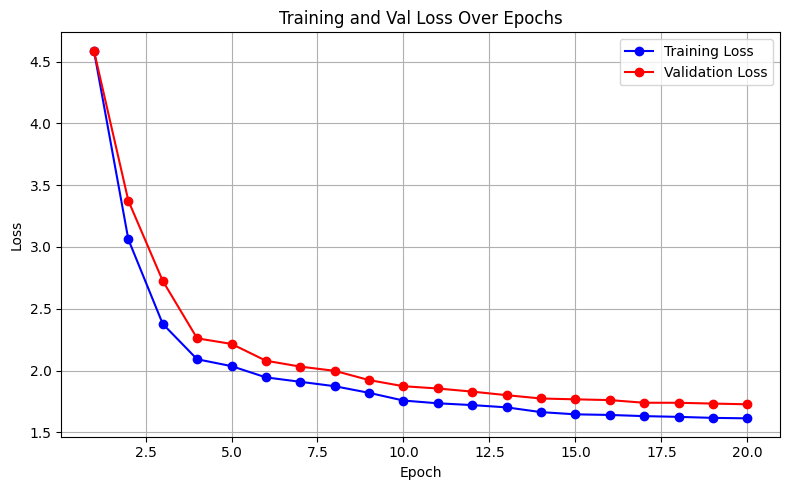

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, steps + 1), result['train_loss'], marker='o', color='blue', label='Training Loss')
plt.plot(range(1, steps + 1), result['test_loss'], marker='o', color='red', label='Validation Loss')
plt.title(f"Training and Val Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Task: Depression
  Balanced Accuracy : 0.493
  ROC AUC           : 0.485
  PR AUC            : 0.321
----------------------------------------
Task: Anxiety
  Balanced Accuracy : 0.621
  ROC AUC           : 0.643
  PR AUC            : 0.609
----------------------------------------
Task: Sleep Disturbance
  Balanced Accuracy : 0.537
  ROC AUC           : 0.643
  PR AUC            : 0.690
----------------------------------------


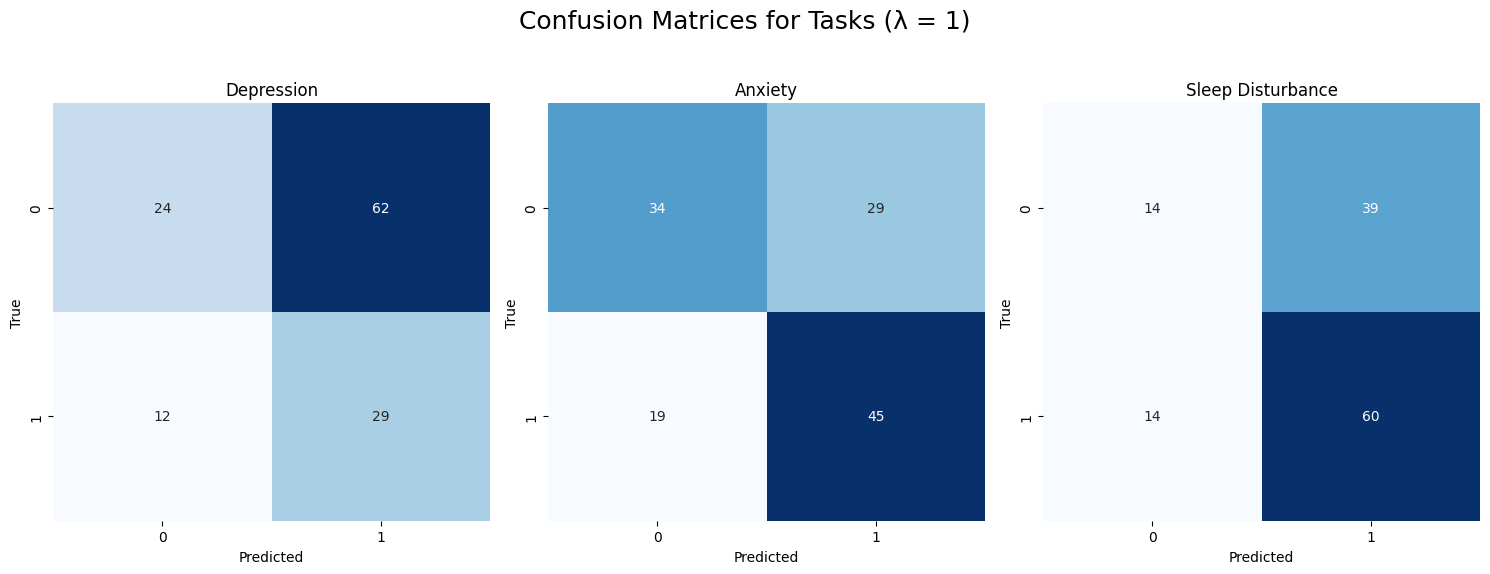

In [ ]:
metrics = {'Task': [], 'Balanced Accuracy': [], 'ROC AUC': [], 'PR AUC': []}
cm_row = []

y_true = dataset["test_label"].cpu().numpy()
output = (torch.sigmoid(model(dataset["test_input"])).detach().cpu().numpy())
pred = np.empty([3, dataset['test_input'].shape[0]])

pred[0] = (output.T[0] >= 0.5).astype(int) # depression
pred[1] = (output.T[1] >= 0.5).astype(int) # anxiety
pred[2] = (output.T[2] >= 0.5).astype(int) # sleep

pred = pred.T

for j, task in enumerate(['Depression', 'Anxiety', 'Sleep Disturbance']):
    y_true_task = y_true[:, j]
    y_score = output[:, j]
    y_pred = pred[:, j]

    bal_acc = balanced_accuracy_score(y_true_task, y_pred)
    roc_auc = roc_auc_score(y_true_task, y_score)
    pr_auc = average_precision_score(y_true_task, y_score)

    metrics['Task'].append(task)
    metrics['Balanced Accuracy'].append(bal_acc)
    metrics['ROC AUC'].append(roc_auc)
    metrics['PR AUC'].append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_true_task, y_pred)
    cm_row.append((task, cm))

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Confusion Matrices for Tasks (λ = 1)', fontsize=18)

for col_idx, (task_name, cm) in enumerate(cm_row):
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[col_idx], cbar=False)
    axes[col_idx].set_title(task_name)
    axes[col_idx].set_xlabel('Predicted')
    axes[col_idx].set_ylabel('True')

    # Get metrics for this task
    task_idx = metrics['Task'].index(task_name)
    bal_acc = metrics['Balanced Accuracy'][task_idx]
    roc_auc = metrics['ROC AUC'][task_idx]
    pr_auc = metrics['PR AUC'][task_idx]

    # Print metrics nicely
    print(f"Task: {task_name}")
    print(f"  Balanced Accuracy : {bal_acc:.3f}")
    print(f"  ROC AUC           : {roc_auc:.3f}")
    print(f"  PR AUC            : {pr_auc:.3f}")
    print("-" * 40)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
pruned_structure = model.state_dict()

model_2 = KAN(width=model.width, grid=model.grid, k=model.k, seed=23, device=model.device)

model_2.load_state_dict(pruned_structure)

checkpoint directory created: ./model
saving model version 0.0


<All keys matched successfully>

# TRAINING ROUND 2

In [ ]:
result_2 = model_2.fit(
    {'train_input': dataset['train_input'], 'train_label': dataset['train_label'], 'test_input': dataset['val_input'], 'test_label': dataset['val_label']},
    opt="LBFGS",
    metrics=(train_acc, val_acc),
    loss_fn=make_custom_loss_fn(lambda_value),
    steps=20
    )

| train_loss: 1.54e+00 | test_loss: 1.69e+00 | reg: 1.55e+02 | : 100%|█| 20/20 [04:33<00:00, 13.68s/

saving model version 0.1


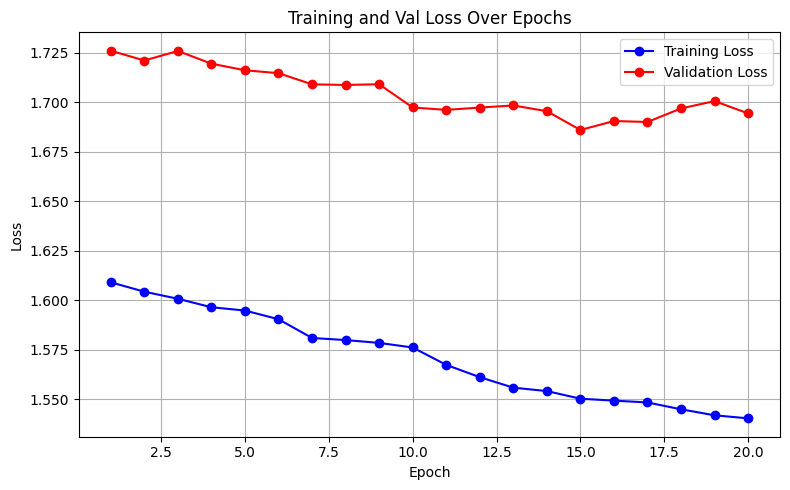

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 20 + 1), result_2['train_loss'], marker='o', color='blue', label='Training Loss')
plt.plot(range(1, 20 + 1), result_2['test_loss'], marker='o', color='red', label='Validation Loss')
plt.title(f"Training and Val Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Task: Depression
  Balanced Accuracy : 0.532
  ROC AUC           : 0.600
  PR AUC            : 0.406
----------------------------------------
Task: Anxiety
  Balanced Accuracy : 0.629
  ROC AUC           : 0.623
  PR AUC            : 0.580
----------------------------------------
Task: Sleep Disturbance
  Balanced Accuracy : 0.569
  ROC AUC           : 0.635
  PR AUC            : 0.675
----------------------------------------


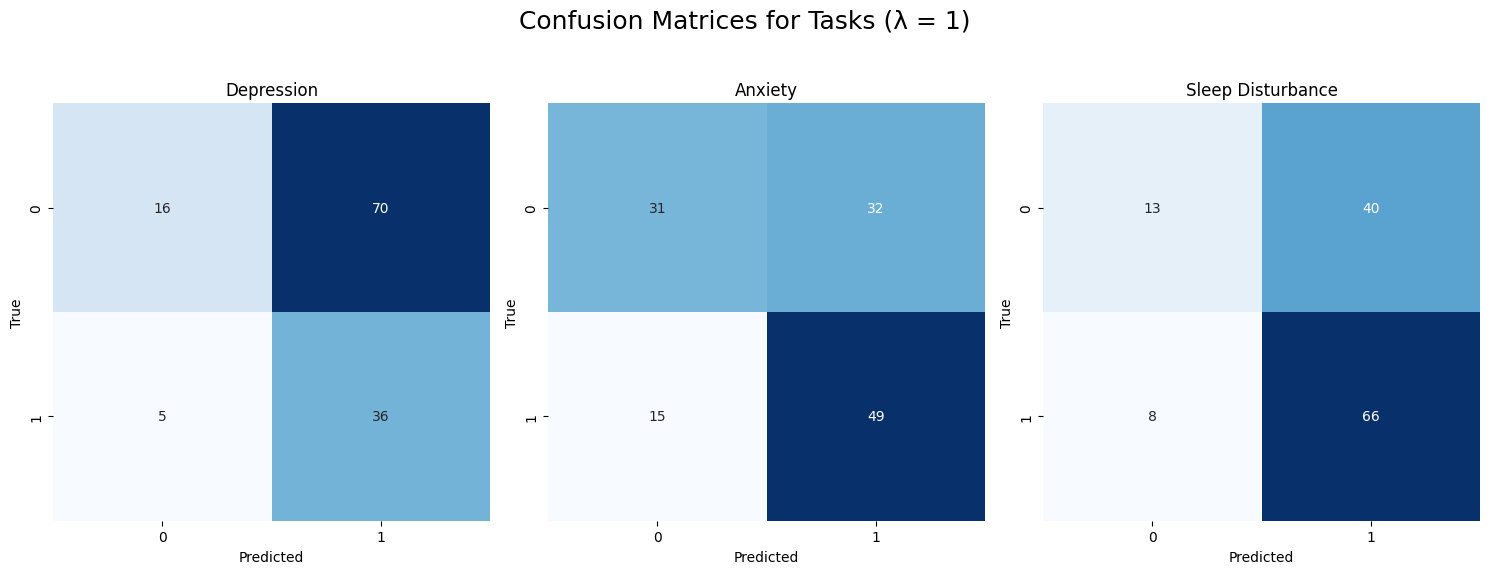

In [ ]:
metrics = {'Task': [], 'Balanced Accuracy': [], 'ROC AUC': [], 'PR AUC': []}
cm_row = []

y_true = dataset["test_label"].cpu().numpy()
output = (torch.sigmoid(model_2(dataset["test_input"])).detach().cpu().numpy())
pred = np.empty([3, dataset['test_input'].shape[0]])

pred[0] = (output.T[0] >= 0.5).astype(int) # depression
pred[1] = (output.T[1] >= 0.5).astype(int) # anxiety
pred[2] = (output.T[2] >= 0.5).astype(int) # sleep

pred = pred.T

for j, task in enumerate(['Depression', 'Anxiety', 'Sleep Disturbance']):
    y_true_task = y_true[:, j]
    y_score = output[:, j]
    y_pred = pred[:, j]

    bal_acc = balanced_accuracy_score(y_true_task, y_pred)
    roc_auc = roc_auc_score(y_true_task, y_score)
    pr_auc = average_precision_score(y_true_task, y_score)

    metrics['Task'].append(task)
    metrics['Balanced Accuracy'].append(bal_acc)
    metrics['ROC AUC'].append(roc_auc)
    metrics['PR AUC'].append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_true_task, y_pred)
    cm_row.append((task, cm))

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Confusion Matrices for Tasks (λ = 1)', fontsize=18)

for col_idx, (task_name, cm) in enumerate(cm_row):
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[col_idx], cbar=False)
    axes[col_idx].set_title(task_name)
    axes[col_idx].set_xlabel('Predicted')
    axes[col_idx].set_ylabel('True')

    # Get metrics for this task
    task_idx = metrics['Task'].index(task_name)
    bal_acc = metrics['Balanced Accuracy'][task_idx]
    roc_auc = metrics['ROC AUC'][task_idx]
    pr_auc = metrics['PR AUC'][task_idx]

    # Print metrics nicely
    print(f"Task: {task_name}")
    print(f"  Balanced Accuracy : {bal_acc:.3f}")
    print(f"  ROC AUC           : {roc_auc:.3f}")
    print(f"  PR AUC            : {pr_auc:.3f}")
    print("-" * 40)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

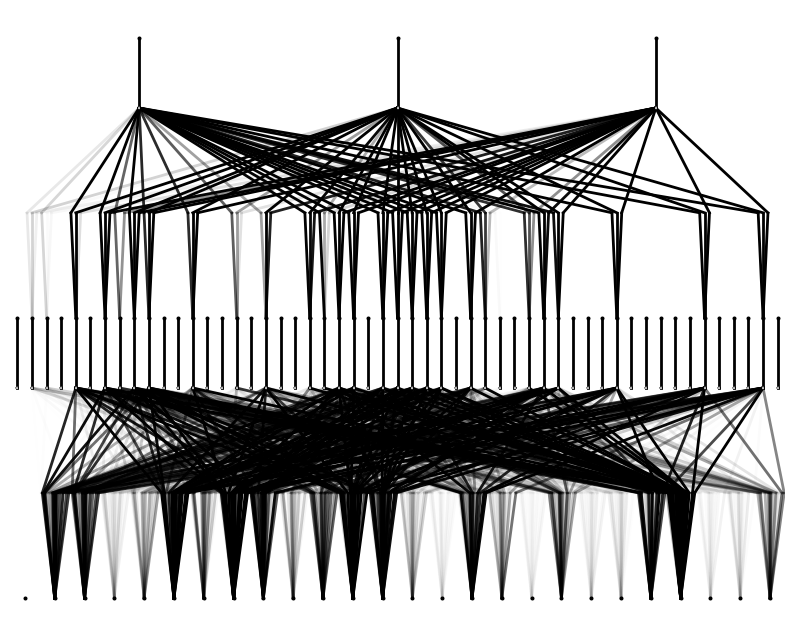

In [ ]:
model_2.plot(scale=1)

In [ ]:
model_2 = model_2.prune()

saving model version 0.2


In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']

model_2.auto_symbolic(lib=lib)
formula_dep, formula_anx, formula_sleep = model_2.symbolic_formula()[0]

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with 0
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,0,6) with 0
fixing (0,0,7) with 0
fixing (0,0,8) with 0
fixing (0,0,9) with 0
fixing (0,0,10) with 0
fixing (0,0,11) with 0
fixing (0,0,12) with 0
fixing (0,0,13) with 0
fixing (0,0,14) with 0
fixing (0,0,15) with 0
fixing (0,0,16) with 0
fixing (0,0,17) with 0
fixing (0,0,18) with 0
fixing (0,0,19) with 0
fixing (0,0,20) with 0
fixing (0,0,21) with 0
fixing (0,0,22) with 0
fixing (0,0,23) with 0
fixing (0,0,24) with 0
fixing (0,0,25) with 0
fixing (0,0,26) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with x, r2=1.0000004768371582, c=1
fixing (0,1,3) with x, r2=1.0000005960464478, c=1
fixing (0,1,4) with 0
fixing (0,1,5) with x, r2=1.0000003576278687, c=1
fixing (0,1,6) with x, r2=1.0000004768371582, c=1
fixing (0,1,7) with x, r2=1.0000003576278687, c=1
fixing (0,1,8) with 0
fixing (0,1,9) with x, r2=1.0000004768371582, c=1
f

# symbolic formula

In [ ]:
formula_dep

0.008068977719446*x_10 + 0.00239612562852245*x_11 - 0.00115175399765793*x_12 + 0.00309813190092154*x_13 + 0.0167758817750742*x_14 - 0.00108147155175885*x_16 + 0.0117312477820348*x_17 + 0.00600538492053128*x_19 - 0.00451526816227786*x_2 - 0.000491394880370375*x_22 - 0.000128783992034852*x_23 + 0.00456370489855135*x_25 - 0.00523289757727761*x_26 + 0.000444555929807105*x_3 + 0.0060111790257472*x_4 + 0.0124931367738523*x_5 - 0.00104542307178269*x_6 + 0.00776606370052147*x_7 + 0.00137191674096843*x_8 - 0.00433258569762825*x_9 - 3.65770791490754*exp(0.0108071097069165*x_12 - 0.0145334561937631*x_23) + 21395970.902498*exp(-0.025036991243127*x_23 + 0.0320204527025309*x_8) - 1.01832925986352*exp(0.00172220879724133*x_13 - 0.000827910563447456*x_23 - 0.00228791151963579*x_8) + 2.10960989242985e-6*exp(-0.0135246861544455*x_12 + 0.020901944526791*x_13 + 0.0213922634896073*x_22 - 0.017749300365392*x_23 + 0.00623507963322821*x_8) + 0.13745662179231*exp(0.00315510533280729*x_12 + 0.0073759046411503*x

In [ ]:
formula_anx

-0.0410898352148669*x_10 - 0.00759568430471108*x_11 + 0.000166115244672829*x_12 + 0.00179602461113337*x_13 + 0.0382921102489109*x_14 + 0.0182345219387596*x_16 + 0.0508830753984075*x_17 + 0.00857198346386674*x_19 - 0.0254295854612784*x_2 - 0.00484732226865512*x_22 + 0.000101669331892731*x_23 + 0.021252602926473*x_25 - 0.00906094648552719*x_26 - 0.0104311764568075*x_3 + 0.02801458590356*x_4 + 0.0225222042272691*x_5 - 0.00180806793610413*x_6 + 0.0020790907161688*x_7 - 0.00126800244449976*x_8 + 0.00409716349181186*x_9 + 4469150814287.99*exp(-0.0214327660162351*x_12 - 0.00502160922066063*x_23) + 1.77372804771615*exp(0.0175811757855361*x_12 - 0.0236432547687017*x_23) + 0.63782951566825*exp(0.00182554272586041*x_13 - 0.000877585870647896*x_23 - 0.00242518807172142*x_8) + 0.000138977748071803*exp(-0.00855476656319703*x_12 + 0.0132211020722884*x_13 + 0.013531243410912*x_22 - 0.0112269607998324*x_23 + 0.00394387345895482*x_8) + 0.0190181840129351*exp(0.00454202538538473*x_12 + 0.0106182021157669

In [ ]:
formula_sleep

-0.00942759636425712*x_10 - 0.00266147495389216*x_11 + 4.34067611043585e-5*x_12 - 0.000378636646838395*x_13 + 0.0445576284543992*x_14 - 0.00060198636847858*x_16 + 0.033186530713892*x_17 + 0.00847515189426229*x_19 - 0.00620043422742853*x_2 + 0.000232161270641785*x_22 + 8.79172847664395e-5*x_23 + 0.009331470820882*x_25 - 0.00548394332110025*x_26 + 0.00098546349533896*x_3 - 0.0210064946516747*x_4 + 0.009357663133311*x_5 - 0.00252905498841511*x_6 + 0.0236207862168546*x_7 - 0.000235309674870695*x_8 - 0.000361929373904824*x_9 - 4.6579550189731*exp(0.00738316049981379*x_12 - 0.00992891185576585*x_23) - 85471.4028796903*exp(-0.0152163511716255*x_23 + 0.0194605832731554*x_8) - 0.00235675131531974*exp(-0.00604536359096945*x_12 + 0.00934290474320478*x_13 + 0.00956207111586014*x_22 - 0.00793371269165104*x_23 + 0.00278700170717996*x_8) + 0.0719037072938186*exp(0.0030445938814454*x_12 + 0.00711755449400161*x_13 - 0.00700169010706571*x_23 - 0.00722645915900933*x_6 - 0.00806058412314643*x_8) + 0.00025

In [ ]:
feature_names = [col.split('_')[0] for col in list(X.columns)]
feature_names[5] = 'date difference'
feature_scores = model_2.feature_score.detach().cpu().numpy()
feature_ranking = sorted(zip(feature_names, feature_scores), key=lambda x: x[1], reverse=True)
print("\nFeature Ranking (Most Important First):")
for i, (name, score) in enumerate(feature_ranking):
    print(f"{i+1}. {name}: {score:.4f}")


Feature Ranking (Most Important First):
1. steps: 383.1746
2. fatburncal: 29.4633
3. lowrangecal: 25.3513
4. date difference: 13.1058
5. lowrangemins: 11.6690
6. fatburnmins: 6.8687
7. bedtimedur: 5.9242
8. minsasleep: 5.2694
9. sedentaryminutes: 5.1877
10. cardiocal: 4.8994
11. lightlyactiveminutes: 3.0889
12. peakcal: 2.2881
13. veryactiveminutes: 1.7478
14. fairlyactiveminutes: 1.3547
15. minsawake: 1.0451
16. complypercent: 0.8902
17. floors: 0.7483
18. meanrate: 0.6515
19. cardiomins: 0.3400
20. sdrate: 0.2282
21. timetobed: 0.2024
22. peakmins: 0.1643
23. timeoutofbed: 0.1316
24. minsafterwakeup: 0.1177
25. minstofallasleep: 0.1021
26. Efficiency: 0.0035



Top features for Depression:
  steps: 21395975.7164
  fatburncal: 21395972.0599
  lowrangecal: 3.7963
  lowrangemins: 1.1591
  date difference: 0.1385


Evaluating symbolic formula on test set: 100%|██████████| 127/127 [00:10<00:00, 12.50it/s]



Depression - Symbolic Formula Performance
  Accuracy           : 0.4094
  Balanced Accuracy  : 0.5320
  ROC AUC            : 0.6078
  PR AUC             : 0.4169
----------------------------------------

Top features for Anxiety:
  steps: 4469150814290.4219
  lowrangecal: 4469150814289.7842
  lowrangemins: 0.6588
  fatburncal: 0.6583
  minsawake: 0.0509


Evaluating symbolic formula on test set: 100%|██████████| 127/127 [00:09<00:00, 13.54it/s]



Anxiety - Symbolic Formula Performance
  Accuracy           : 0.6220
  Balanced Accuracy  : 0.6212
  ROC AUC            : 0.6272
  PR AUC             : 0.5801
----------------------------------------

Top features for Sleep Disturbance:
  steps: 85476.1354
  fatburncal: 85471.4776
  lowrangecal: 4.7323
  lowrangemins: 0.0749
  date difference: 0.0744


Evaluating symbolic formula on test set: 100%|██████████| 127/127 [00:08<00:00, 14.53it/s]



Sleep Disturbance - Symbolic Formula Performance
  Accuracy           : 0.6142
  Balanced Accuracy  : 0.5592
  ROC AUC            : 0.6178
  PR AUC             : 0.6803
----------------------------------------


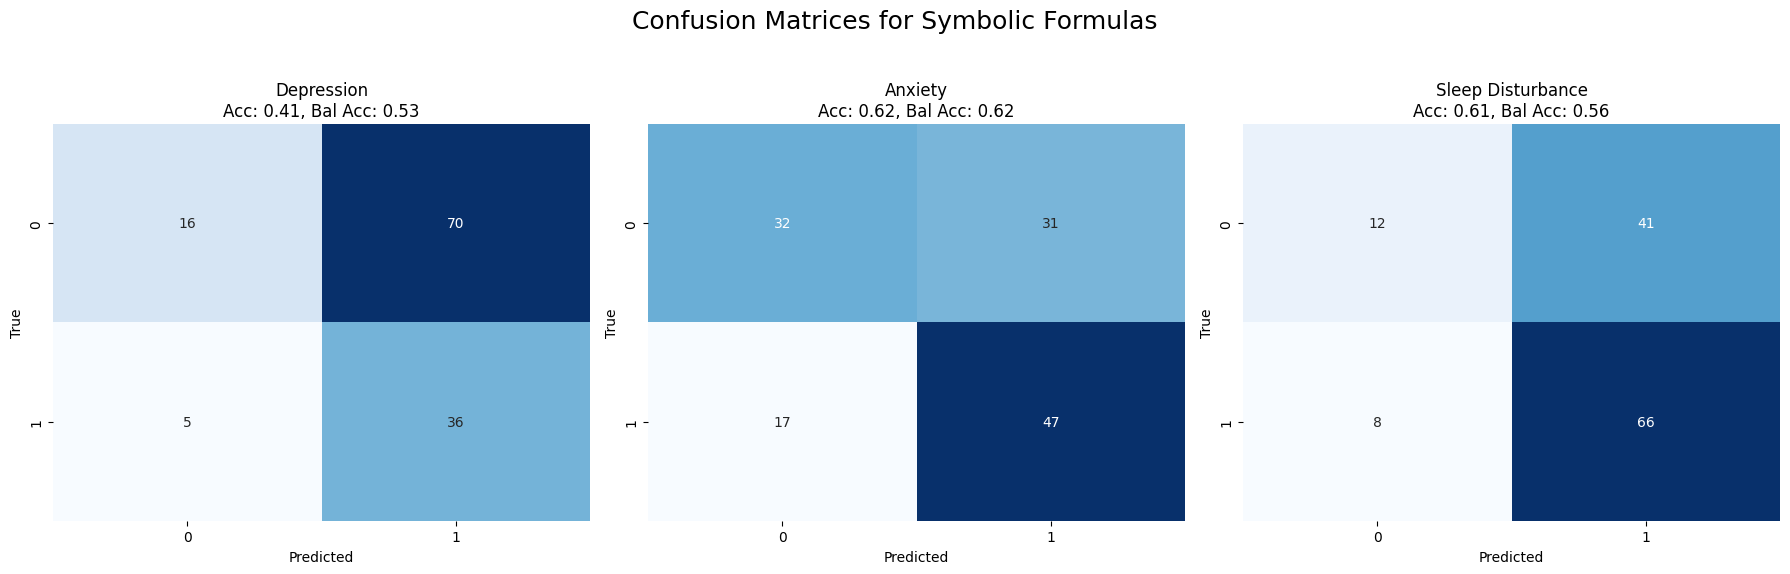

In [ ]:
def kan_symbolic_formula_prediction_test(formula, X):
    """Evaluate a symbolic formula on X and return predictions."""
    batch = X.shape[0]
    predictions = []

    for i in tqdm(range(batch), desc="Evaluating symbolic formula on test set"):
        substitutions = {sympy.Symbol(f'x_{j+1}'): X[i, j] for j in range(X.shape[1])}
        evaluated_expression = formula.subs(substitutions)
        predictions.append(float(evaluated_expression.evalf()))

    return predictions

def extract_feature_importance(formula, feature_names):
    """Extract variables from formula and rank them by coefficient magnitude."""
    importance = {}
    for term in formula.as_ordered_terms():
        coeff = term.as_coeff_Mul()[0]
        vars_in_term = [str(v) for v in term.free_symbols]
        for var in vars_in_term:
            if var.startswith("x_"):
                feat_idx = int(var.split("_")[1]) - 1
                feat_name = feature_names[feat_idx]
                importance[feat_name] = importance.get(feat_name, 0) + abs(float(coeff))
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    return sorted_features

formulas = {
    "Depression": formula_dep,
    "Anxiety": formula_anx,
    "Sleep Disturbance": formula_sleep
}

y_true_all = dataset['test_label'].cpu().numpy()
X_test_np = dataset['test_input'].cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Confusion Matrices for Symbolic Formulas", fontsize=18)


for idx, (task_name, formula) in enumerate(formulas.items()):
    sorted_feats = extract_feature_importance(formula, feature_names)
    print(f"\nTop features for {task_name}:")
    for feat, score in sorted_feats[:5]:
        print(f"  {feat}: {score:.4f}")

    preds_raw = kan_symbolic_formula_prediction_test(formula, X_test_np)
    preds_sigmoid = torch.sigmoid(torch.tensor(preds_raw)).numpy().flatten()
    preds_binary = (preds_sigmoid > 0.5).astype(int)

    y_true_task = y_true_all[:, idx].astype(int)

    acc = accuracy_score(y_true_task, preds_binary)
    bal_acc = balanced_accuracy_score(y_true_task, preds_binary)
    roc_auc = roc_auc_score(y_true_task, preds_sigmoid)
    pr_auc = average_precision_score(y_true_task, preds_sigmoid)

    print(f"\n{task_name} - Symbolic Formula Performance")
    print(f"  Accuracy           : {acc:.4f}")
    print(f"  Balanced Accuracy  : {bal_acc:.4f}")
    print(f"  ROC AUC            : {roc_auc:.4f}")
    print(f"  PR AUC             : {pr_auc:.4f}")
    print("-" * 40)

    cm = confusion_matrix(y_true_task, preds_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f"{task_name}\nAcc: {acc:.2f}, Bal Acc: {bal_acc:.2f}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
